In [1]:
import nltk, random
from nltk.corpus import movie_reviews
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import sys
sys.path.append(sys.path[0] + '/..')

from aprendizajeAutomatico import entrenamiento, prediccion


nltk.download("movie_reviews")

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\denny\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


True

# Cargando datos

In [2]:
print(len(movie_reviews.fileids()))
print(movie_reviews.categories())
print(movie_reviews.words()[:100])
print(movie_reviews.fileids()[:10])

3000
['neg', 'pos']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]
['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt', 'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt', 'neg/cv009_29417.txt']


Organización de los datos del corpus como una lista de tuplas, donde el primer elemento son los tokens de palabras de los documentos y el segundo es la etiqueta (pos --> positivo, neg --> negativo)

In [3]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.seed(123)
random.shuffle(documents)

Estadística básica

In [4]:
print('Number of Reviews/Documents: {}'.format(len(documents)))
print('Corpus Size (words): {}'.format(np.sum([len(d) for (d,l) in documents])))
print('Sample Text of Doc 1:')
print('-'*30)
print(' '.join(documents[0][0][:50])) # first 50 words of the first document
print(''.join(documents[0][1][:3])) # etiqueta de clasificación

Number of Reviews/Documents: 3000
Corpus Size (words): 2335076
Sample Text of Doc 1:
------------------------------
if this keeps up , jane austen ( sense and sensibility , pride and prejudice ) may have to apply for posthumous membership to the screen writers guild . yet another novel of hers has made the transition to the silver screen . mansfield park is a turn of the
pos


In [5]:
## Check Sentiment Distribution of the Current Dataset
from collections import Counter
sentiment_distr = Counter([label for (words, label) in documents])
print(sentiment_distr)

Counter({'neg': 2000, 'pos': 1000})


Entrenamiento y pruebas

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(documents, test_size = 0.20, random_state=50)
print(Counter([label for (words, label) in train]))
print(Counter([label for (words, label) in test]))

Counter({'neg': 1588, 'pos': 812})
Counter({'neg': 412, 'pos': 188})


In [7]:
X_train = [' '.join(words) for (words, label) in train]
X_test = [' '.join(words) for (words, label) in test]
y_train = [label for (words, label) in train]
y_test = [label for (words, label) in test]

Vectorización del texto

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vec = TfidfVectorizer(min_df = 10, token_pattern = r'[a-zA-Z]+')
X_train_bow = tfidf_vec.fit_transform(X_train) 
X_test_bow = tfidf_vec.transform(X_test) 

In [9]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(2400, 9132)
(600, 9132)


Selección de modelos y validación cruzada. Se prueban algunos algoritmos de clasificación comunes:
- Máquinas de vectores soporte
- Árbol de decisión
- Naive Bayes
- Regresión logística

In [10]:
svc = svm.SVC(C=8.0, kernel='linear')
dtree = DecisionTreeClassifier(max_depth=10, random_state=0)
gnb = GaussianNB()
lg = LogisticRegression()

clifs = [svc, dtree, gnb, lg]

modelos = {}
for clf in clifs:
    modelos[clf.__class__.__name__] = entrenamiento.entrenar_cross_score(modelo=clf, X_train=X_train_bow, y_train=y_train, esBinario=True)

In [11]:
for m in modelos:
    print('\nModelo: ', m)
    print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format('Predicción 1', 'Predicción 2', 'Predicción 3', 'Predicción 4', 'Predicción 5'))
    print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format('----------------', '----------------', '----------------', '----------------', '----------------'))
    print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format(modelos[m][1]['prediccion 0'], modelos[m][1]['prediccion 1'], modelos[m][1]['prediccion 2'], modelos[m][1]['prediccion 3'], modelos[m][1]['prediccion 4']))


Modelo:  SVC
Predicción 1         Predicción 2         Predicción 3         Predicción 4         Predicción 5        
----------------     ----------------     ----------------     ----------------     ----------------    
0.9208333333333333   0.8916666666666667   0.9083333333333333   0.9083333333333333   0.8979166666666667  

Modelo:  DecisionTreeClassifier
Predicción 1         Predicción 2         Predicción 3         Predicción 4         Predicción 5        
----------------     ----------------     ----------------     ----------------     ----------------    
0.7604166666666666   0.775                0.7041666666666667   0.7770833333333333   0.73125             

Modelo:  GaussianNB
Predicción 1         Predicción 2         Predicción 3         Predicción 4         Predicción 5        
----------------     ----------------     ----------------     ----------------     ----------------    
0.7770833333333333   0.7604166666666666   0.7708333333333334   0.7541666666666667   0.73125 

## Evaluación
Para evaluar el rendimiento de cada modelo, se utilizan varias métricas comunes:
- Precision
- Recall
- F-score
- Accuracy
- Confusion Matrix

In [12]:
print ("{:<25} {:<20}".format('Modelo', 'Prección'))
print ("{:<25} {:<20}".format('----------------', '----------------'))
for clf in clifs:
    nombre_modelo = clf.__class__.__name__
    if 'GaussianNB' == nombre_modelo:
        print ("{:<25} {:<20}".format(nombre_modelo, clf.score(X_test_bow.toarray(), y_test)))
    else:
        print ("{:<25} {:<20}".format(nombre_modelo, clf.score(X_test_bow, y_test)))

Modelo                    Prección            
----------------          ----------------    
SVC                       0.94                
DecisionTreeClassifier    0.7783333333333333  
GaussianNB                0.7783333333333333  
LogisticRegression        0.8366666666666667  


In [13]:
# F1 Score del modelo que mejor predicción tiene: SVC
from sklearn.metrics import f1_score

y_pred = svc.predict(X_test_bow)
f1_score(y_test, y_pred, 
         average=None, 
         labels = movie_reviews.categories())

array([0.95774648, 0.89655172])

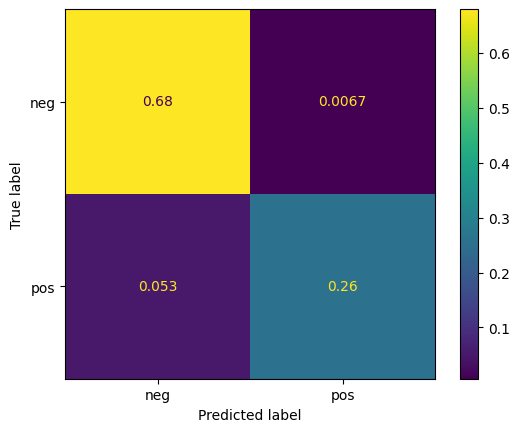

In [14]:
# Matriz de confusión SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plot_confusion_matrix(svc, X_test_bow, y_test, normalize='all')

Buscar la mejor parametrización para el modelo SVC utilizando GridSerarchCV

In [15]:
%%time

from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc_nuevo = svm.SVC()
clf = GridSearchCV(svc_nuevo, parameters, cv=10, n_jobs=-1)
clf.fit(X_train_bow, y_train)

CPU times: total: 11.5 s
Wall time: 4min 36s


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

In [16]:
#print(sorted(clf.cv_results_.keys()))
print(clf.best_params_)
print(clf.score(X_test_bow, y_test))

{'C': 4, 'kernel': 'linear'}
0.94


Uso de LIME para interpretar la predicción del modelo

In [17]:
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import Pipeline

## Refit model based on optimal parameter settings
pipeline = Pipeline([
  ('vectorizer',tfidf_vec), 
  ('clf', svm.SVC(C=1, kernel='linear', probability=True))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=10, token_pattern='[a-zA-Z]+')),
                ('clf', SVC(C=1, kernel='linear', probability=True))])

In [18]:
import textwrap
reviews_test = X_test
sentiments_test = y_test

# We choose a sample from test set
idx = 210
text_sample = reviews_test[idx]
class_names = ['negative', 'positive']

print('Review ID-{}:'.format(idx))
print('-'*50)
print('Review Text:\n', textwrap.fill(text_sample,400))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('Probability(negative) =', pipeline.predict_proba([text_sample])[0,0])
print('Predicted class: %s' % pipeline.predict([text_sample]))
print('True class: %s' % sentiments_test[idx])

Review ID-210:
--------------------------------------------------
Review Text:
 the best thing about , " lake placid " is that it ' s only 80 minutes long and when it ' s over you ' re glad that you didn ' t waste more than an hour and a half of your time . it ' s nothing more than a bad rip - off of , " jaws " ( and i think that ' s being kind . ) it was written by david e . kelly ( " ally mcbeal " ) as a horror - comedy but fails at both , miserably . i was never scared and
i think that i only laughed once . the crocodile even fails in comparison to the snake in , " anaconda . " the plot begins when a man is eaten in half by the giant crocodile in black lake in maine . that brings the local sheriff ( brendan gleeson ) and a fish - and - game warden ( bill pulman ) to investigate . also , a paleontologist ( bridget fonda ) from new york is sent to look at a tooth and
an eccentric millionaire / crocodile lover ( oliver platt ) flies in because he wants to swim beside the beast . soon t

In [19]:
from tkinter.ttk import Style
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=300
%matplotlib inline

plt.style.use('dark_background')

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, 
                                         pipeline.predict_proba, 
                                         num_features=20)
explanation.show_in_notebook(text=True)
#fig.savefig("decistion_tree.png")

Otra forma de evaluar la importancia de las características es observar sus coeficientes correspondientes

In [20]:
## Extract the coefficients of the model from the pipeline
importances = pipeline.named_steps['clf'].coef_.toarray().flatten()
## Select top 10 positive/negative weights
top_indices_pos = np.argsort(importances)[::-1][:10] 
top_indices_neg = np.argsort(importances)[:10]
## Get featnames from tfidfvectorizer
feature_names = np.array(tfidf_vec.get_feature_names()) # List indexing is different from array

feature_importance_df = pd.DataFrame({'FEATURE': feature_names[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'IMPORTANCE': importances[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'SENTIMENT': ['pos' for _ in range(len(top_indices_pos))]+['neg' for _ in range(len(top_indices_neg))]})
feature_importance_df

,FEATURE,IMPORTANCE,SENTIMENT
0,and,2.335982,pos
1,great,1.866703,pos
2,fun,1.854243,pos
3,also,1.625069,pos
4,well,1.608198,pos
5,seen,1.533470,pos
6,excellent,1.509935,pos
7,perfectly,1.496946,pos
8,horror,1.464408,pos
9,american,1.459441,pos


Text(0.5, 1.0, 'Feature Importance: Top Words')

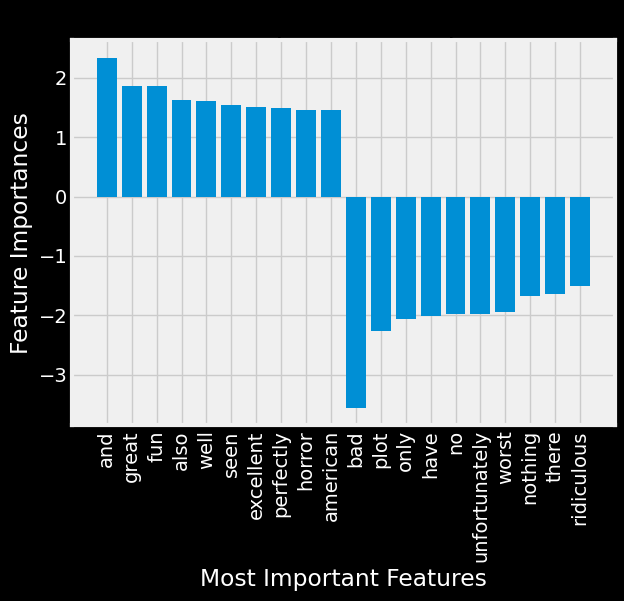

In [21]:
plt.figure(figsize=(7,5), dpi=100)
plt.style.use('fivethirtyeight')
plt.bar(x = feature_importance_df['FEATURE'], height=feature_importance_df['IMPORTANCE'])
plt.xlabel("Most Important Features")
plt.ylabel("Feature Importances")
plt.xticks(rotation=90)
plt.title("Feature Importance: Top Words", color="black")

Visualización para los clasificadores basados ​​en árboles:

In [22]:
import sklearn
from sklearn.tree import plot_tree
text_representation = sklearn.tree.export_text(dtree, feature_names = tfidf_vec.get_feature_names())
print(text_representation)

|--- bad <= 0.01
|   |--- and <= 0.15
|   |   |--- have <= 0.02
|   |   |   |--- life <= 0.00
|   |   |   |   |--- t <= 0.02
|   |   |   |   |   |--- though <= 0.00
|   |   |   |   |   |   |--- time <= 0.02
|   |   |   |   |   |   |   |--- is <= 0.13
|   |   |   |   |   |   |   |   |--- after <= 0.02
|   |   |   |   |   |   |   |   |   |--- own <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |   |   |   |--- own >  0.03
|   |   |   |   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |   |   |   |--- after >  0.02
|   |   |   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |   |   |--- is >  0.13
|   |   |   |   |   |   |   |   |--- down <= 0.02
|   |   |   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |   |   |   |--- down >  0.02
|   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |--- time >  0.02
|   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |--- though >  0.00
|  

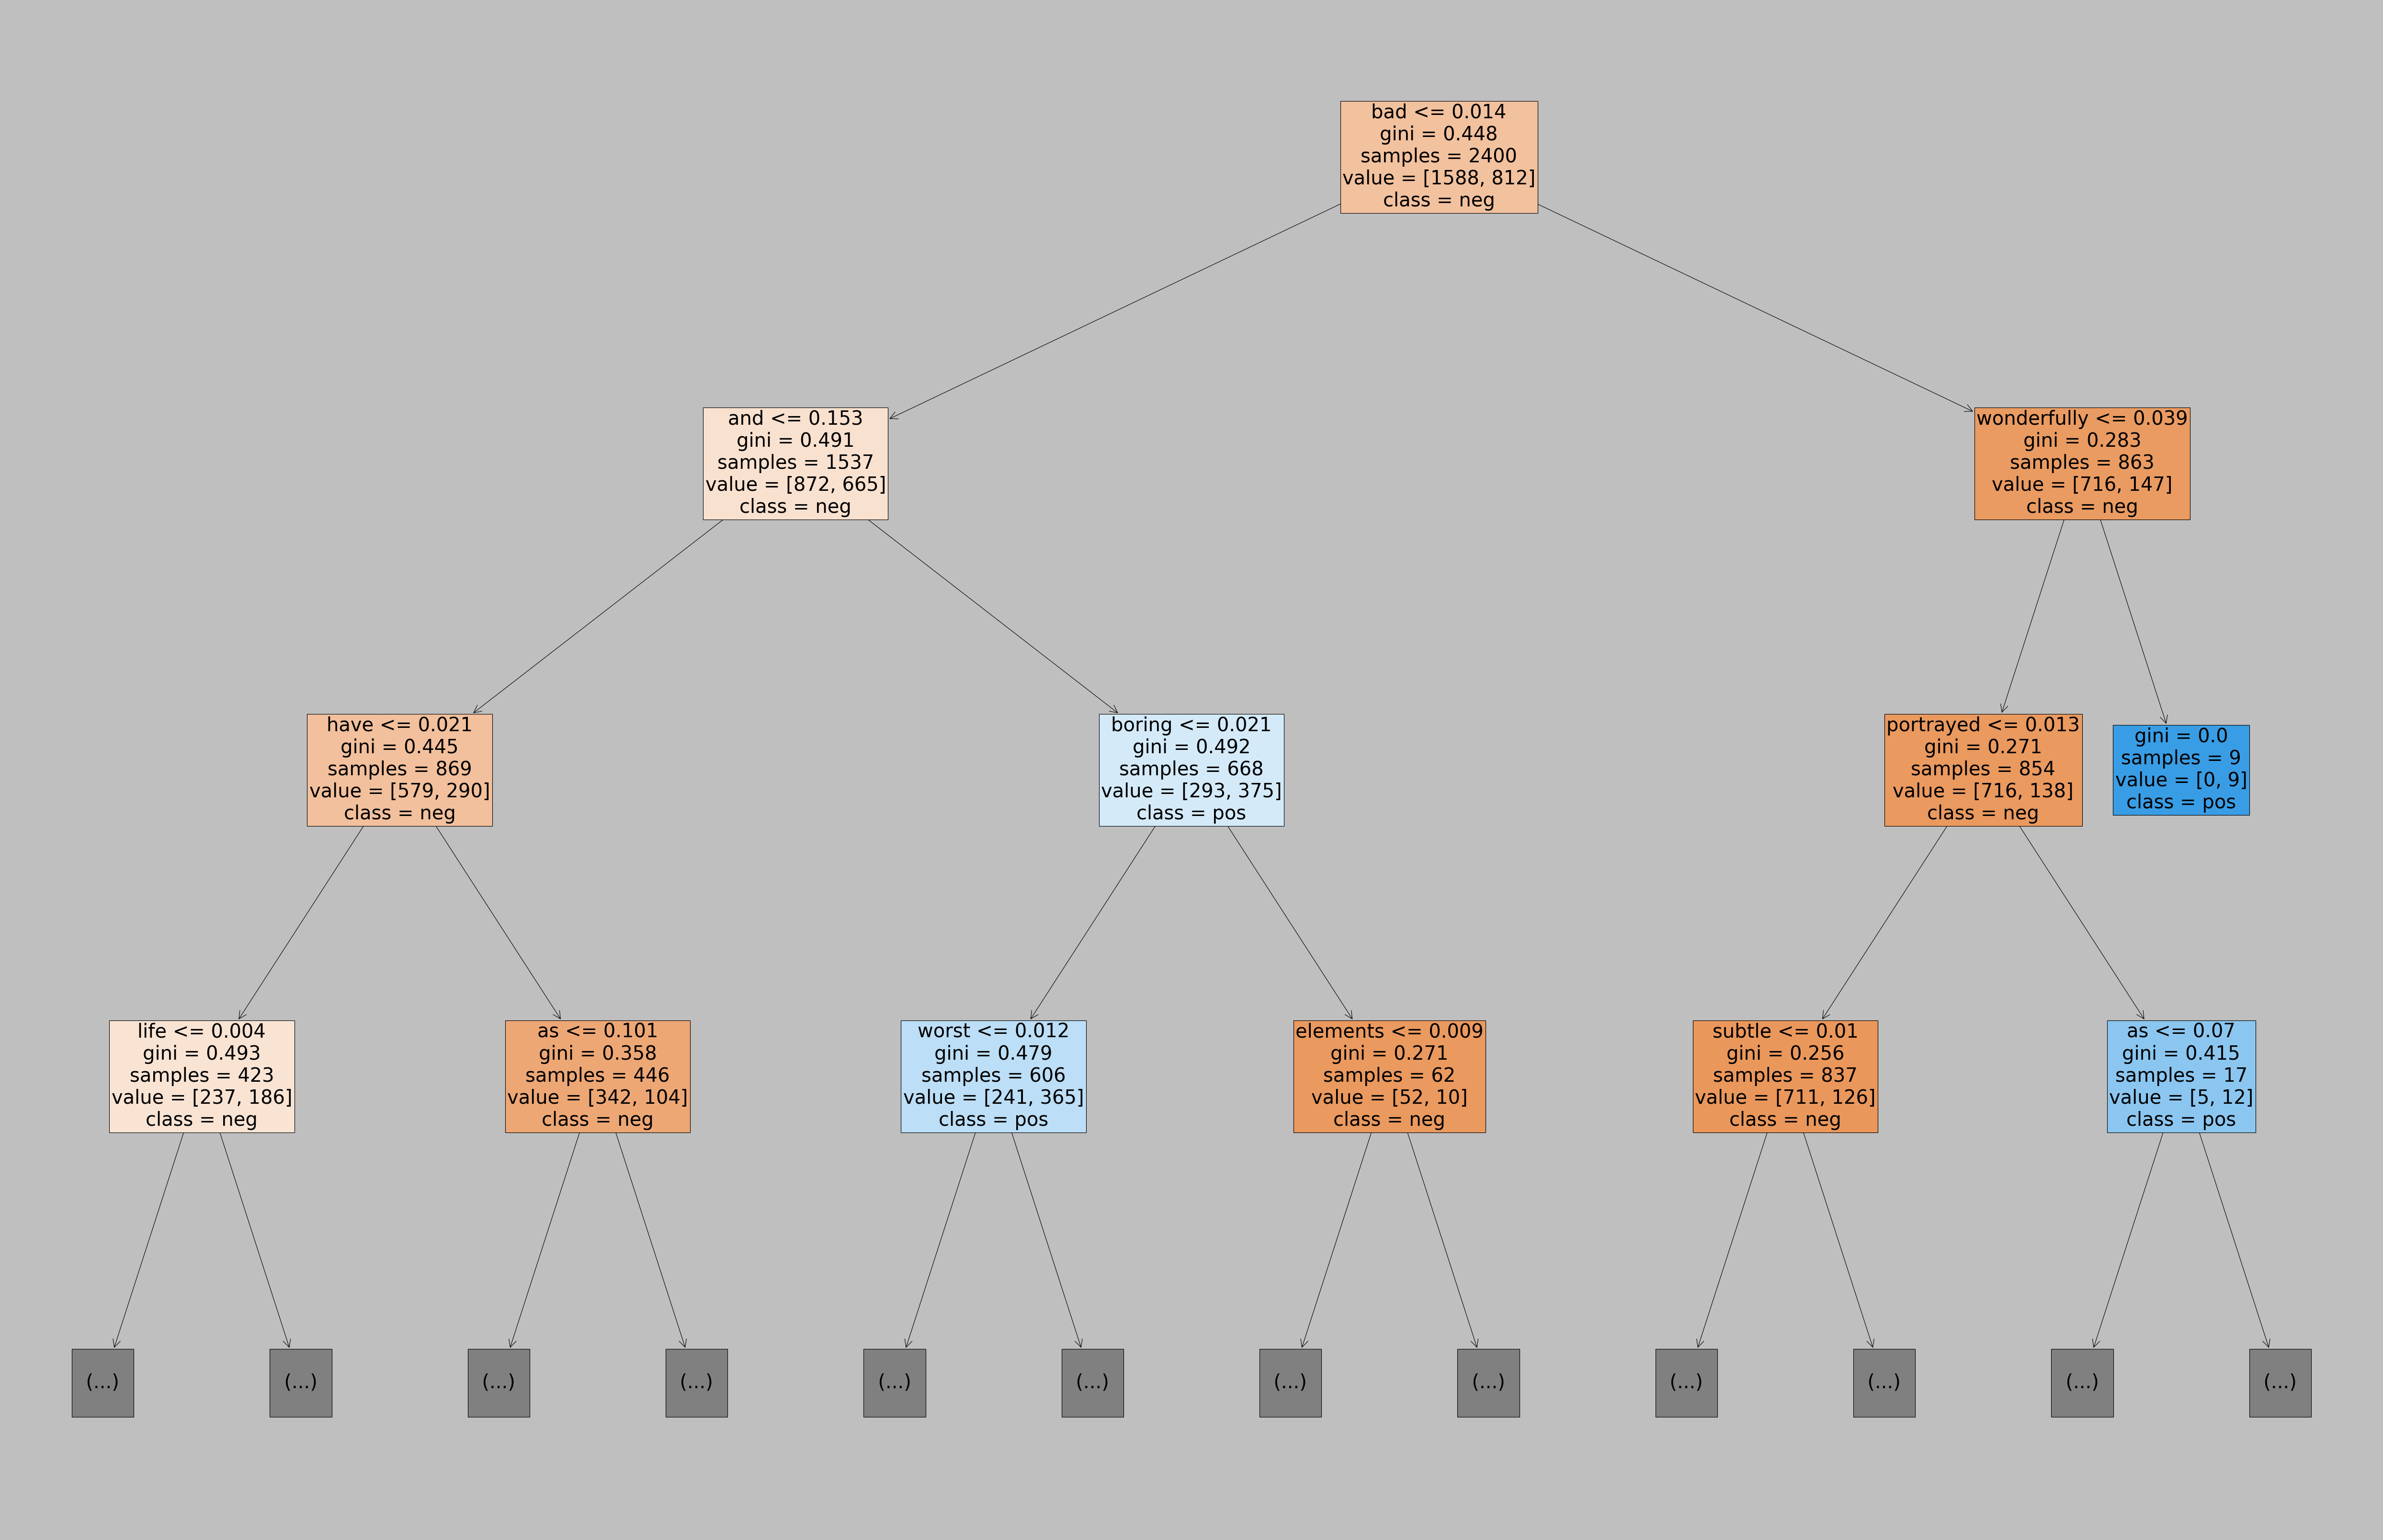

In [23]:
plt.style.use('classic')
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(80,50))
_ = sklearn.tree.plot_tree(dtree, max_depth=3,
                   feature_names=tfidf_vec.get_feature_names(),  
                   class_names=dtree.classes_,
                   filled=True, fontsize=36)

#fig.savefig("decistion_tree.png")

## Clasificador de sentimiento

In [24]:
from textblob import TextBlob

doc_sent = TextBlob(X_train[0])
print(doc_sent.sentiment)
print(doc_sent.sentiment.polarity)

Sentiment(polarity=0.102808658008658, subjectivity=0.528165367965368)
0.102808658008658


In [25]:
doc_sents = [TextBlob(doc).sentiment.polarity for doc in X_train]
y_train[:10]

['neg', 'neg', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos']

In [26]:
doc_sents_prediction = ['pos' if score >= 0.1 else 'neg' for score in doc_sents]
doc_sents_prediction[:10]

['pos', 'neg', 'neg', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos']

In [27]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
print(accuracy_score(y_train, doc_sents_prediction))
print(f1_score(y_train, doc_sents_prediction, average=None, labels=['neg','pos']))

0.7504166666666666
[0.80444009 0.65515256]


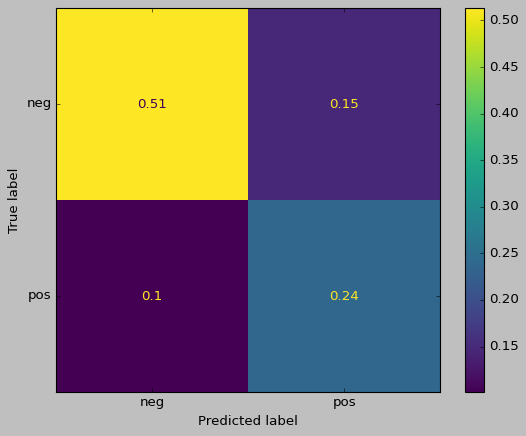

In [28]:
ConfusionMatrixDisplay(confusion_matrix(y_train, doc_sents_prediction, normalize="all"), display_labels=['neg','pos']).plot()


AFINN Lexicon

In [29]:
from afinn import Afinn

In [30]:
afn = Afinn(emoticons=True)

afn.score("This movie, not good. worth it :( But can give it a try!! worth it")

0.0

In [31]:
doc_sents_afn = [afn.score(d) for d in X_train]
doc_sents_afn_prediction = ['pos' if score >= 1.0 else 'neg' for score in doc_sents_afn]
print(accuracy_score(y_train, doc_sents_afn_prediction))
print(f1_score(y_train, doc_sents_afn_prediction, average=None, labels=['neg','pos']))

0.6191666666666666
[0.64463453 0.58976661]


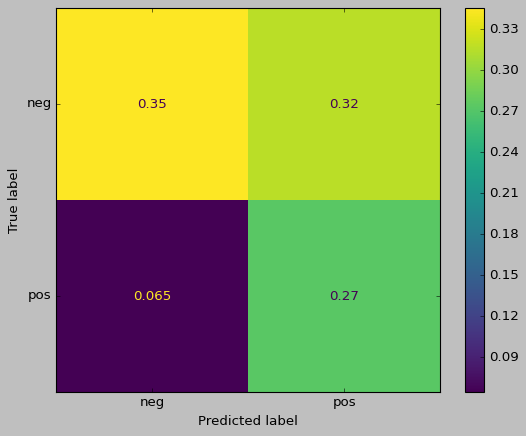

In [32]:
ConfusionMatrixDisplay(confusion_matrix(y_train, doc_sents_afn_prediction, normalize="all"),display_labels=['neg','pos']).plot()

## Predicción de la letra de canción

Verificación de los mejores parámetros identificados en el modelo SVC

In [33]:
svc = svm.SVC(C=4, kernel='rbf')
m = svc.__class__.__name__
modelos[m] = entrenamiento.entrenar_cross_score(svc, X_train_bow, y_train, True)

print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format('Predicción 1', 'Predicción 2', 'Predicción 3', 'Predicción 4', 'Predicción 5'))
print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format('----------------', '----------------', '----------------', '----------------', '----------------'))
print ("{:<20} {:<20} {:<20} {:<20} {:<20}".format(modelos[m][1]['prediccion 0'], modelos[m][1]['prediccion 1'], modelos[m][1]['prediccion 2'], modelos[m][1]['prediccion 3'], modelos[m][1]['prediccion 4']))

Predicción 1         Predicción 2         Predicción 3         Predicción 4         Predicción 5        
----------------     ----------------     ----------------     ----------------     ----------------    
0.9083333333333333   0.90625              0.8916666666666667   0.9                  0.9104166666666667  


Obtiene letra de canción preprocesada

In [41]:
from bdd import mongoDB_cliente
from aprendizajeAutomatico import prediccion

cantante = 'JC LA NEVULA / ATOMIC OTRO WAY'
cancion = 'BUSCATE OTRO'

canciones = mongoDB_cliente.obtenerColeccion('CANCIONES', {'cantante': cantante, 'cancion': cancion})   
letra_preprocesada = canciones[0]['letra_preprocesada']
letra_original = canciones[0]['letra']
array_letra = {}
letra_cancion_pre = ''
for letra in letra_preprocesada:
        letra_cancion_pre = letra_cancion_pre + letra + " "
array_letra = [letra_cancion_pre]
array_letra_o = [letra_original]


In [42]:
array = array_letra_o

letra_bow = tfidf_vec.transform(array)
prediccion = svc.predict(letra_bow)
print(prediccion)
if 'neg' == prediccion:
    prediccion = 'NEGATIVO'
else:
    prediccion = 'POSITIVO'

print(prediccion)
     

['neg']
NEGATIVO


In [36]:
from logica import cancion_logica
from sentimientos import sentimientoMultiple

cancion_logica.actualizarCancionSentimientoBinario(canciones[0], prediccion)

'documento actualizado correctamente'